In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# prompt: mount drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/data.zip -d /content/data

Streaming output truncated to the last 5000 lines.
  inflating: /content/data/data/train/present/UID_35_10_3_all.jpg  
  inflating: /content/data/data/train/present/UID_35_10_5_all.jpg  
  inflating: /content/data/data/train/present/UID_35_10_6_all.jpg  
  inflating: /content/data/data/train/present/UID_35_10_7_all.jpg  
  inflating: /content/data/data/train/present/UID_35_11_10_all.jpg  
  inflating: /content/data/data/train/present/UID_35_11_1_all.jpg  
  inflating: /content/data/data/train/present/UID_35_11_2_all.jpg  
  inflating: /content/data/data/train/present/UID_35_11_4_all.jpg  
  inflating: /content/data/data/train/present/UID_35_11_5_all.jpg  
  inflating: /content/data/data/train/present/UID_35_11_8_all.jpg  
  inflating: /content/data/data/train/present/UID_35_12_10_all.jpg  
  inflating: /content/data/data/train/present/UID_35_12_11_all.jpg  
  inflating: /content/data/data/train/present/UID_35_12_1_all.jpg  
  inflating: /content/data/data/train/present/UID_35_12_2_all.

In [ ]:
from tensorflow.keras.layers import Dense, Flatten, Input, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.models import Sequential
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [ ]:
train_path = "/content/data/data/train"
val_path = "/content/data/data/validation"
test_path = "/content/data/data/test"

In [ ]:
IMAGE_SIZE = [224,224]

In [ ]:
# Scaling all the images between 0 to 1

train_datagen = ImageDataGenerator(rescale = 1./255, rotation_range=30,           # Rotate images by up to 30 degrees
    width_shift_range=0.05,       # Translate horizontally by 20% of the width
    height_shift_range=0.05,      # Translate vertically by 20% of the height
    shear_range=0.1,             # Apply shear transformation
    zoom_range=0.1,              # Random zoom by up to 20%
    horizontal_flip=True,        # Flip images horizontally
    brightness_range=[0.8, 1.2],)
# Performing only scaling on the test dataset

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_set = train_datagen.flow_from_directory(train_path,
                                              target_size=(224,224),
                                              batch_size=16,
                                              class_mode = 'categorical')

val_set = train_datagen.flow_from_directory(
    val_path,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size=(224,224),
                                            batch_size=16,
                                            class_mode='categorical')

Found 9616 images belonging to 2 classes.
Found 2062 images belonging to 2 classes.
Found 2060 images belonging to 2 classes.


In [ ]:

from tensorflow.keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = tf.reduce_sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = tf.reduce_sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def precision_m(y_true, y_pred):
    true_positives = tf.reduce_sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = tf.reduce_sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives / (predicted_positives + K.epsilon())

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))


In [ ]:
from keras.metrics import Precision, Recall
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model

learning_rate_reduction = ReduceLROnPlateau(
    monitor="val_accuracy", patience=3, verbose=1, factor=0.3, min_lr=0.0000001
)
early_stop = EarlyStopping(
    patience=10,
    verbose=1,
    monitor="val_accuracy",
    mode="max",
    min_delta=0.001,
    restore_best_weights=True,
)

In [ ]:
ML_Model = []
accuracy = []
precision = []
recall = []
f1score = []

#function to call for storing the results
def storeResults(model, a,b,c,d):
    ML_Model.append(model)
    accuracy.append(round(a, 3))
    precision.append(round(b, 3))
    recall.append(round(c, 3))
    f1score.append(round(d, 3))

# VGG19

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19

In [ ]:
vgg19=VGG19(input_shape = IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [ ]:
x1= Flatten()(vgg19.output)
prediction1 = Dense(2, activation='softmax')(x1)
model1 = Model(inputs = vgg19.inputs, outputs = prediction1)
model1.summary()
model1.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=["accuracy",f1_m,precision_m, recall_m])

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,074,562 (76.58 MB)

 Trainable params: 20,074,562 (76.58 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
hist1 = model1.fit(train_set, validation_data=val_set, epochs=30, steps_per_epoch=len(train_set), validation_steps=len(val_set),callbacks=[learning_rate_reduction, early_stop])

Epoch 1/30
601/601 ━━━━━━━━━━━━━━━━━━━━ 240s 385ms/step - accuracy: 0.5004 - f1_m: 0.5004 - loss: 0.8991 - precision_m: 0.5004 - recall_m: 0.5004 - val_accuracy: 0.5000 - val_f1_m: 0.4999 - val_loss: 0.6931 - val_precision_m: 0.4999 - val_recall_m: 0.4999 - learning_rate: 0.0010
Epoch 2/30
601/601 ━━━━━━━━━━━━━━━━━━━━ 229s 380ms/step - accuracy: 0.4955 - f1_m: 0.4955 - loss: 0.6932 - precision_m: 0.4955 - recall_m: 0.4955 - val_accuracy: 0.5000 - val_f1_m: 0.4997 - val_loss: 0.6932 - val_precision_m: 0.4997 - val_recall_m: 0.4997 - learning_rate: 0.0010
Epoch 3/30
601/601 ━━━━━━━━━━━━━━━━━━━━ 262s 380ms/step - accuracy: 0.4951 - f1_m: 0.4951 - loss: 0.6932 - precision_m: 0.4951 - recall_m: 0.4951 - val_accuracy: 0.5000 - val_f1_m: 0.5001 - val_loss: 0.6932 - val_precision_m: 0.5001 - val_recall_m: 0.5001 - learning_rate: 0.0010
Epoch 4/30
601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.5000 - f1_m: 0.5000 - loss: 0.6933 - precision_m: 0.5000 - recall_m: 0.5000
Epoch 4: ReduceL

In [ ]:
scores = model1.evaluate(test_set)
storeResults("VGG19", scores[1], scores[2], scores[3], scores[4])

129/129 ━━━━━━━━━━━━━━━━━━━━ 16s 122ms/step - accuracy: 0.4910 - f1_m: 0.4910 - loss: 0.6932 - precision_m: 0.4910 - recall_m: 0.4910


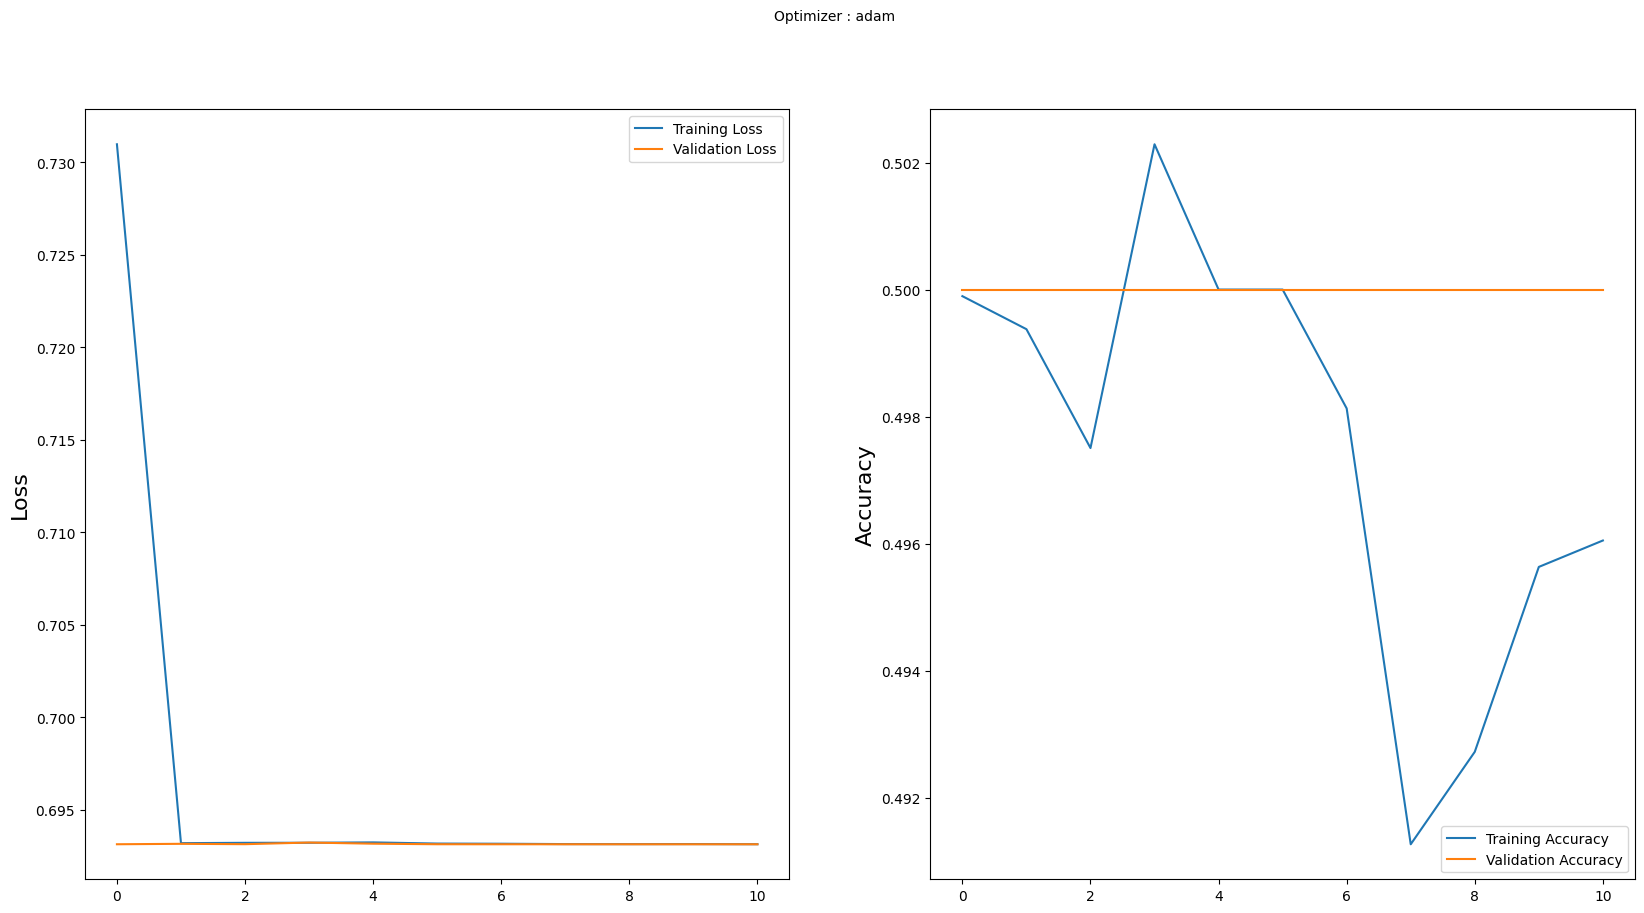

In [ ]:
import matplotlib.pyplot as plt

x=hist1
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(x.history['loss'], label='Training Loss')
plt.plot(x.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(x.history['accuracy'], label='Training Accuracy')
plt.plot(x.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Save training history to a JSON file
import json
history_dict = hist1.history
with open(f"/content/drive/MyDrive/{'VGG19'}_history.json", "w") as f:
    json.dump(history_dict, f)


In [ ]:
print(hist1.history['accuracy'][-1])
print(hist1.history['precision_m'][-1])
print(hist1.history['recall_m'][-1])
print(hist1.history['f1_m'][-1])


0.496048241853714
0.496048241853714
0.496048241853714
0.4960482120513916
